In [25]:
import matplotlib.pyplot as plt
import frogress
import astropy.io.fits as fits
import healpy as hp
import numpy as np
import glob
import healsparse
import astropy.io.fits as fits

def convert_to_pix_coord(ra, dec, nside=1024):
    """
    Converts RA,DEC to hpix coordinates
    """
    theta = (90.0 - dec) * np.pi / 180.
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    return pix

# Determine area new deep fields from Will

These are some new files from Will.
One caveat - in the templates we're using for BFD, we're setting 
'KNN_CLASS' == 1
Now, 'KNN_CLASS' == 0, are mostly galaxies; we're not using them for BFD, but I will include them in the 
computation of the deep field number densities as upper limit

In [2]:
count = 0
for i, name in enumerate(['COSMOS_masked_cat','SN-C3_masked_cat','SN-E2_masked_cat','SN-X3_masked_cat']):
    cosmos = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/DF_will_2024/{0}.fits'.format(name))
    id_ = cosmos[1].data['id']
    mask_df = (cosmos[1].data['MASK_FLAGS']==0) & (cosmos[1].data['FLAGS']==0) & (cosmos[1].data['FLAGS_NIR']==0)& (cosmos[1].data['MASK_FLAGS_NIR']==0)  & (cosmos[1].data['KNN_CLASS']<=1)
    count += id_[mask_df].shape[0]
    if i == 0:
        good_coadd_id = id_[mask_df]
    else:
        good_coadd_id = np.hstack([good_coadd_id,id_[mask_df]])
    
total_area = 0.893+1.340+1.103+1.297
number_density_DF_upper_limit = count/total_area/3600.
#np.save('../data/good_area_DF_IDs',good_coadd_id)

count = 0
for i, name in enumerate(['COSMOS_masked_cat','SN-C3_masked_cat','SN-E2_masked_cat','SN-X3_masked_cat']):
    cosmos = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/DF_will_2024/{0}.fits'.format(name))
    id_ = cosmos[1].data['id']
    mask_df = (cosmos[1].data['MASK_FLAGS']==0) & (cosmos[1].data['FLAGS']==0) & (cosmos[1].data['FLAGS_NIR']==0)& (cosmos[1].data['MASK_FLAGS_NIR']==0)  & (cosmos[1].data['KNN_CLASS']==1)
    count += id_[mask_df].shape[0]
   

number_density_DF_BFD = count/total_area/3600.


print ('New number density (upper limit): ', number_density_DF_upper_limit)
print ('New number density (used by BFD): ', number_density_DF_BFD)


New number density (upper limit):  83.8020121351656
New number density (used by BFD):  73.22529198743315


# trim templates files

Here I am simply loading the summary_templates.fits file generated by the BFD pipeline and apply Will's mask.

In [3]:
templates = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/templates/summary_templates.fits')
good_coadd_id = np.load('../data/good_area_DF_IDs.npy',allow_pickle=True)
mask = np.in1d(templates[1].data['coadd_ID'],good_coadd_id)

input_file_path = '/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/templates/summary_templates.fits'
output_file_path = '/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/summary_templates_trimmed.fits'
with fits.open(input_file_path) as hdul:

    # Assuming the first extension is a table that you want to mask
    data = hdul[1].data
    
    # Apply the mask to filter rows
    masked_data = data[mask]
    
    # Create a new HDU (Header/Data Unit) for the masked data
    new_hdu = fits.BinTableHDU(masked_data)
    
    # Write the masked data to a new FITS file
    new_hdu.writeto(output_file_path, overwrite=True)


# Compute WF area

We use the targets file with no star-galaxy sep. applied to estimate the WF area.
Since we estimate the area looking at the not-empty healpix pixels, we use the file with no star-galaxy separation
to increase the number density.

AREA WF [deg^2] 4386.469369707927


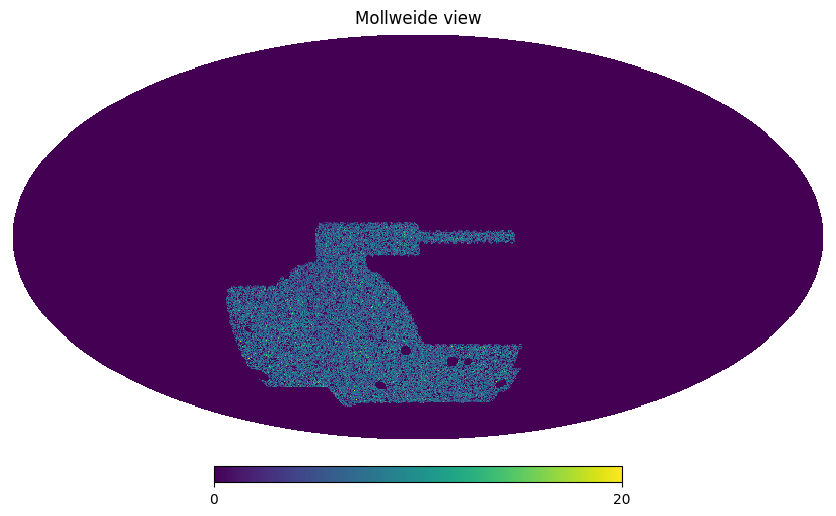

In [4]:
nside = 4096*2

# Load MASK---
fname = '/global/cfs/cdirs/des/y6-shear-catalogs/y6-combined-hleda-gaiafull-des-stars-hsmap16384-nomdet-v3.fits'
hmap = healsparse.HealSparseMap.read(fname)


full = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/extra_files/targets_extrainfo_no_SG_sep.fits')
ra = full[1].data['ra']
dec = full[1].data['dec']

in_footprint = hmap.get_values_pos(
        ra,dec, valid_mask=True)

ra = ra[in_footprint]
dec = dec[in_footprint]


pix = convert_to_pix_coord(ra,dec, nside=nside)

n_counts = np.zeros((12*nside**2))
# make a map --------------------
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)          
n_counts[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))
pix_area = hp.pixelfunc.nside2pixarea(nside,degrees=True)*3600

# Area in deg ----
area_WF = len(n_counts[n_counts!=0])*pix_area/3600
print ('AREA WF [deg^2]', area_WF)
hp.mollview(n_counts)

# Make WF covariance maps for Mf and Mr

We still use the targets files with no star-galaxy sep.

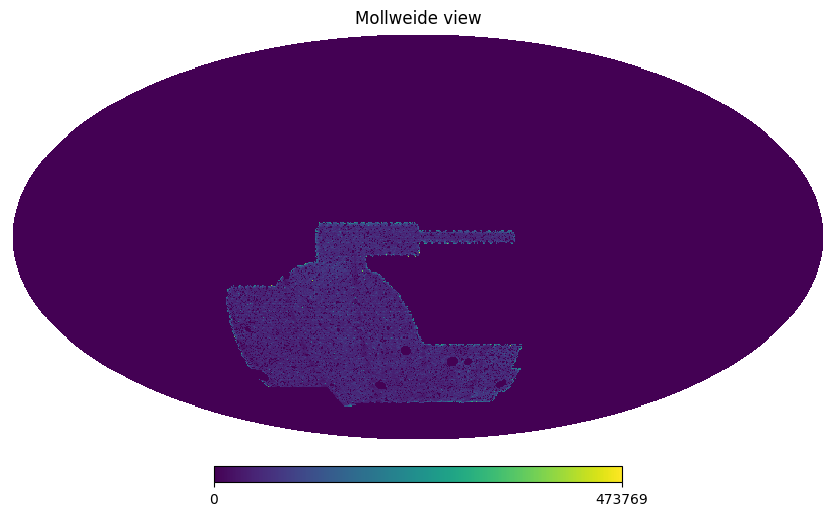

In [5]:
full2 = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/extra_files/targets_no_SG_sep.fits')
cov_full = full2[1].data['covariance']


Mf_covariance_map = np.zeros(12*nside**2)
MfMr_covariance_map = np.zeros(12*nside**2)
Mr_covariance_map = np.zeros(12*nside**2)

pix = convert_to_pix_coord(ra,dec, nside =nside)
unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)


Mf_covariance_map[unique_pix] +=   np.bincount(idx_rep, weights=cov_full[in_footprint,0])
MfMr_covariance_map[unique_pix] += np.bincount(idx_rep, weights=cov_full[in_footprint,1])
Mr_covariance_map[unique_pix] +=   np.bincount(idx_rep, weights=cov_full[in_footprint,5])

Mf_covariance_map[n_counts!=0] /=n_counts[n_counts!=0]
MfMr_covariance_map[n_counts!=0] /=n_counts[n_counts!=0]
Mr_covariance_map[n_counts!=0] /=n_counts[n_counts!=0]

hp.mollview(Mf_covariance_map)

In [ ]:
# make a covariance map for the i-band flux.
Mf_i_covariance_map = np.zeros(12*nside**2)
Mf_i_covariance_map[unique_pix] +=   np.bincount(idx_rep, weights=full[1].data['cov_Mf_per_band'][in_footprint,2])
Mf_i_covariance_map[n_counts!=0] /=n_counts[n_counts!=0]

# Load WF catalog and apply cuts

Let's load the catalog with the SG separation (Mr/Mf<3.5 already applied). For sake's of simplicity, let's apply a simple SN cut

In [9]:

targets = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/targets.fits')
targets_extrainfo = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/targets_extrainfo.fits')


Mf = targets[1].data['moments'][:,0]
Mr = targets[1].data['moments'][:,1]
covariance = targets[1].data['covariance']

ra = targets_extrainfo[1].data['ra']
dec = targets_extrainfo[1].data['dec']


# SN cut
sn =  (Mf/np.sqrt(covariance[:,0]))
mask_sn = (sn>7) & (sn<200)

# big objects
mask = (targets[1].data['moments'][:,1]/targets[1].data['moments'][:,0] > 2.2) 

# targets in the footprint
in_footprint = hmap.get_values_pos( ra,dec, valid_mask=True)

# total mask
mask = mask & in_footprint & mask_sn
print (len(ra[mask]))

# mag_i
bfd_wf_mag_i = -2.5 * np.log10(targets_extrainfo[1].data['Mf_per_band'][mask,2]) + 30

215504962


/tmp/ipykernel_2218018/1072178727.py:28: RuntimeWarning: invalid value encountered in log10
  bfd_wf_mag_i = -2.5 * np.log10(targets_extrainfo[1].data['Mf_per_band'][mask,2]) + 30


# Load DF catalog

In [15]:
# this factor is for the number density upper limit --

bfd_templates = fits.open('/global/cfs/cdirs/des/mgatti/BFD_targets_newrun/summary_templates_trimmed.fits')
bfd_mag_i = -2.5 * np.log10(bfd_templates[1].data['Mf_band'][:,2]) + 30

corr_factor = number_density_DF_upper_limit /((len(bfd_mag_i)/total_area/3600.))

mf_temp = bfd_templates[1].data['moments'][:,0]
mr_temp = bfd_templates[1].data['moments'][:,1]

/tmp/ipykernel_2218018/2073386306.py:4: RuntimeWarning: invalid value encountered in log10
  bfd_mag_i = -2.5 * np.log10(bfd_templates[1].data['Mf_band'][:,2]) + 30


# Assign noise to each deep field entry

In [16]:
index = np.random.randint(0,len(pix),len(bfd_mag_i))
pix_df = pix[index]
#
cov_ff_df = Mf_covariance_map[pix_df]
cov_fr_df = MfMr_covariance_map[pix_df]
cov_rr_df = Mr_covariance_map[pix_df]

moments_errors = []
for i in frogress.bar(range(len(pix_df))):
    cov_matrix = [[cov_ff_df[i], cov_fr_df[i]], [cov_fr_df[i], cov_rr_df[i]]]
    mean = [0, 0]  # Assuming mean of both variables is 0, adjust as needed
    moments_errors.append(np.random.multivariate_normal(np.zeros(2), cov_matrix, 1)[0])
moments_errors = np.array(moments_errors)

100.0% | [##########] | Progress: 1185072 / 1185072 | Time: 1min28s | ETA: --0ss

In [39]:
cov_Mf_i_df = Mf_i_covariance_map[pix_df]

Mf_i_errors = []
for i in frogress.bar(range(len(pix_df))):
    err = np.sqrt(cov_Mf_i_df[i])
    mean = [0, 0]  # Assuming mean of both variables is 0, adjust as needed
    Mf_i_errors.append(np.random.normal(0, err, 1)[0])
Mf_i_errors = np.array(Mf_i_errors)


bfd_mag_i_with_err = -2.5 * np.log10((bfd_templates[1].data['Mf_band'][:,2]+Mf_i_errors)) + 30


100.0% | [##########] | Progress: 1185072 / 1185072 | Time: 8.7s | ETA: --0s

/tmp/ipykernel_2218018/3828252008.py:11: RuntimeWarning: invalid value encountered in log10
  bfd_mag_i_with_err = -2.5 * np.log10((bfd_templates[1].data['Mf_band'][:,2]+Mf_i_errors)) + 30


# Add noise to DF and apply cuts

In [22]:
sn = (mf_temp+moments_errors[:,0])/np.sqrt(cov_ff_df)
mask_DF = (sn>7) & (sn<200)

# apply SG sep to deep field
ratio = (mr_temp+moments_errors[:,1])/(mf_temp+moments_errors[:,0])
mask_DF = (sn>7) & (sn<200) & (ratio>2.2) & (ratio<3.5)

# Get plots!

In [40]:
xx = 100
N_WF,bins_mag_i= np.histogram((bfd_wf_mag_i), bins = np.linspace(15,25,xx))
N_DF_with_err,bins_mag_i= np.histogram((bfd_mag_i_with_err)[mask_DF], bins = np.linspace(15,25,xx))


Text(0, 0.5, '$n_{gal}$ [counts/arcmin^2]')

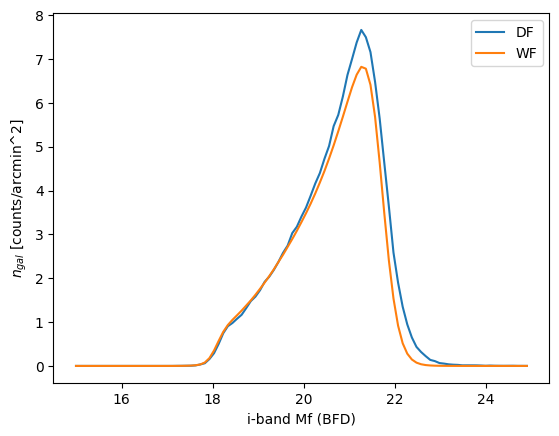

In [48]:
dmag = bins_mag_i[1]-bins_mag_i[0]
plt.plot(bins_mag_i[:-1],N_DF_with_err/total_area/3600./dmag,label = 'DF')
plt.plot(bins_mag_i[:-1],N_WF/area_WF/3600./dmag,label = 'WF')
plt.legend()
plt.xlabel('i-band Mf (BFD)')
plt.ylabel('$n_{gal}$ [counts/arcmin^2]')

/tmp/ipykernel_2218018/2081104828.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(bins_mag_i[:-1],f_DF/f_WF,label = 'DF/WF')


(0.0, 3.0)

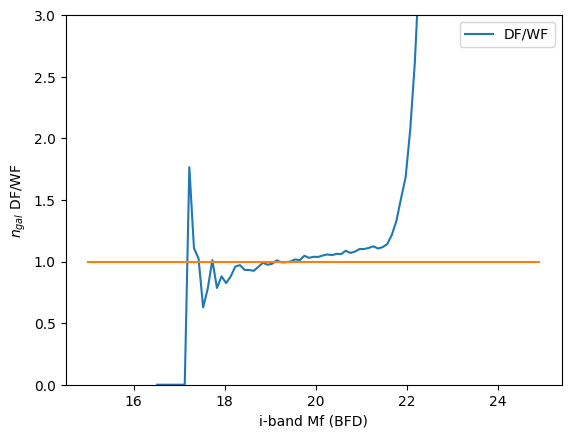

In [49]:
dmag = bins_mag_i[1]-bins_mag_i[0]
f_DF = N_DF_with_err/total_area/3600./dmag
f_WF = N_WF/area_WF/3600./dmag
plt.plot(bins_mag_i[:-1],f_DF/f_WF,label = 'DF/WF')
plt.plot(bins_mag_i[:-1],np.ones(len(f_WF)))
plt.legend()
plt.xlabel('i-band Mf (BFD)')
plt.ylabel('$n_{gal}$ DF/WF')
plt.ylim([0,3])